# Market Regime Classification for the S&P 500 Index

# Antonio Rosolia

Table of Contents:
* Import Data and Preprocess
* K-Means
* DBSCAN
* Feature Engineering
* Summary

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

## Import Data

The data can be imported from the task "Next-day return prediction for the S&P 500 Index", as they are already preprocessed and ready to use.

In [2]:
df = pd.read_pickle("./df.pkl")
df = df.dropna()
df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return
DATE,,,,,,
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,0.711487
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,0.211800
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,0.000000
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,1.479691
1993-02-05,492100.0,44.968727,45.062578,44.718757,44.968792,-0.069295


It is examined whether it makes sense to transform the data with PCA in order to achieve a better clustering. Both strategies are examined.

In [3]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(df)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

## K-Means

To determine the optimal number of clusters, an elbow plot is used.

Normal Data


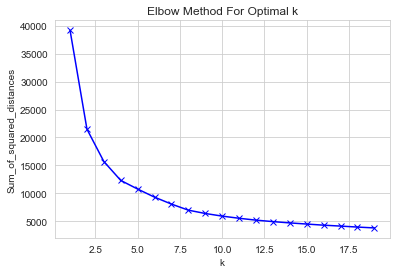

PCA Data


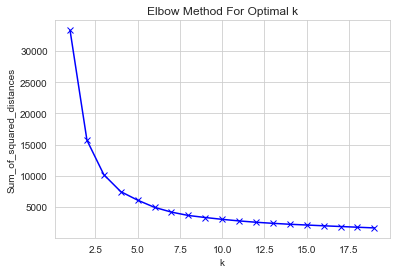

In [4]:
def find_k(K, X):
    Sum_of_squared_distances = []
    for k in range(1,K):
        km = KMeans(n_clusters=k,
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300, 
                    random_state=0)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)
    elbow_plot(K, Sum_of_squared_distances)

def elbow_plot(K, Sum_of_squared_distances):
    plt.plot(range(1,K), Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

print("Normal Data")
find_k(20, X)

print("PCA Data")
find_k(20, X_pca)

It seems, that the optimal number of clusters in both cases is 4.

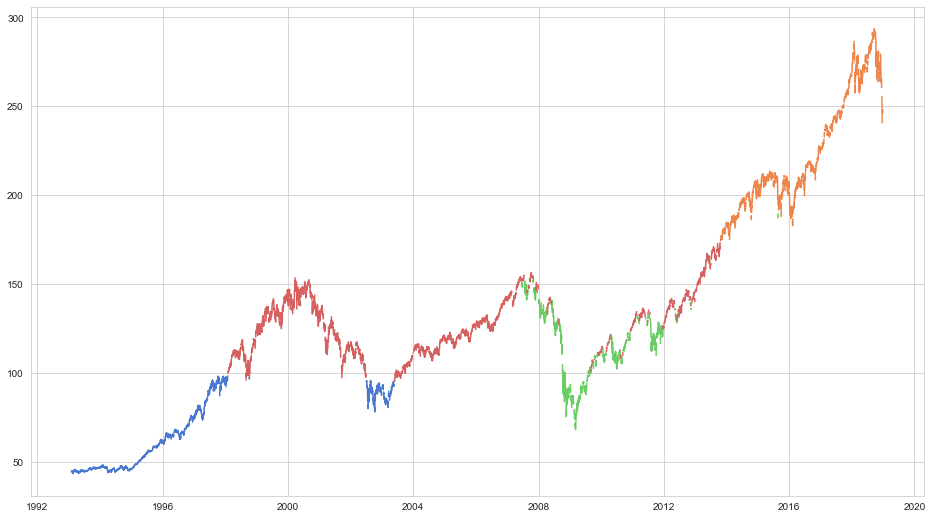

In [5]:
def plot_market_regimes(n_regimes, df):
    fig = plt.figure(figsize=(16,9))
    cmap = sns.color_palette("muted", n_regimes)
    for n in range(0, n_regimes):
        close = df[df["clustering"]==n]["CLOSE"]
        close = close.asfreq('D')
        plt.plot(close, color = cmap[n])
    return fig

n_clusters = 4
km = KMeans(n_clusters=n_clusters,
            init='k-means++', 
            n_init=n_clusters, 
            max_iter=300, 
            random_state=0)
y = km.fit_predict(X)

df_plot = df.copy(deep=True)
df_plot["clustering"] = y

fig = plot_market_regimes(n_clusters, df_plot)

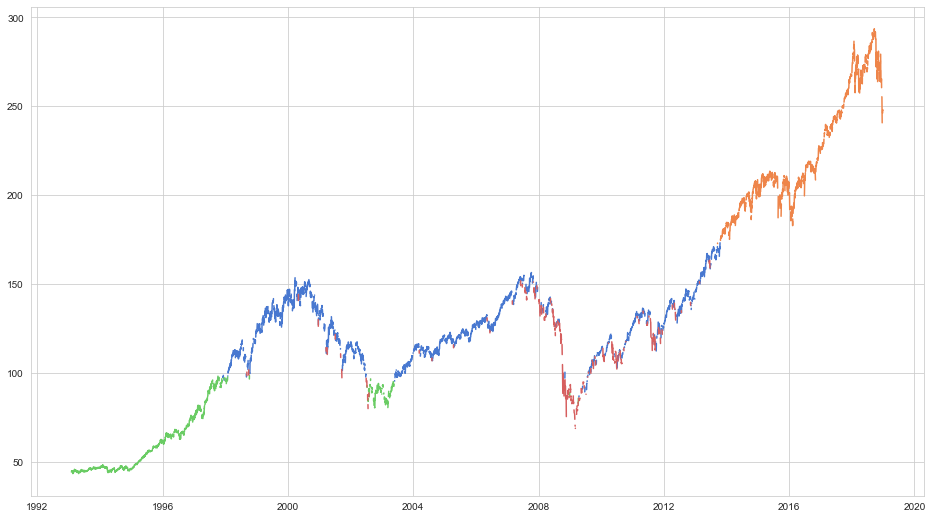

In [6]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters,
            init='k-means++', 
            n_init=n_clusters, 
            max_iter=300, 
            random_state=0)
y = km.fit_predict(X_pca)

df_plot = df.copy(deep=True)
df_plot["clustering"] = y

fig = plot_market_regimes(n_clusters, df_plot)

In both cases, the clustering makes no sense, as it groups how high the price is and not the market regimes. Let's try DBSCAN, as this algorithm does not need a number of clusters a priori.

5


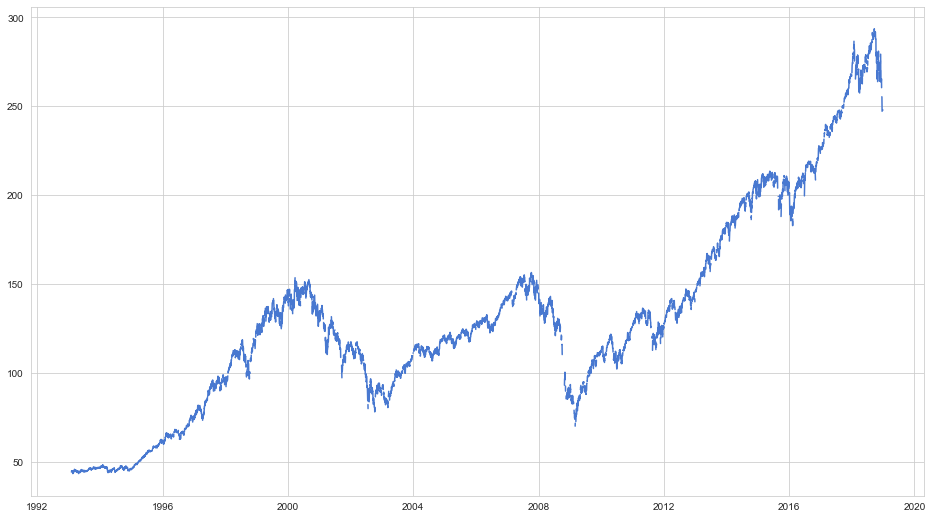

In [7]:
#eps 0.7 was used, as it resulted in 5 clusters
dbscan = DBSCAN(min_samples=3, eps=0.7)
db = dbscan.fit(X)
y = db.labels_.tolist()
n_clusters = pd.Series(y).nunique()

df_plot = df.copy(deep=True)
df_plot["clustering"] = y
print(n_clusters)
fig = plot_market_regimes(n_clusters, df_plot)


In [8]:
y = pd.Series(y)
y.value_counts()

 0    6443
-1      62
 3      15
 2       4
 1       3
dtype: int64

DBSCAN completely fails to cluster anything.

## Feature Engineering

Another attempt will be made with K-Means++ as it was able to cluster the market regime well for the SPY between 100 and 150. 

In [9]:
df_new = df.copy(deep=True)
df_new["C/V"] = df_new["CLOSE"]/df_new["VOLUME"]
df_new["abs_OC"] = abs(df_new["OPEN"]-df_new["CLOSE"])
df_new = df_new.drop(["VOLUME", "OPEN", "HIGH", "LOW", "CLOSE"], axis=1)
df_new = df_new.dropna()
df_new.head()

,Return,C/V,abs_OC
DATE,,,
1993-02-01,0.711487,0.000092,0.281157
1993-02-02,0.211800,0.000220,0.124944
1993-02-03,0.000000,0.000084,0.062588
1993-02-04,1.479691,0.000085,0.031337
1993-02-05,-0.069295,0.000091,0.000065


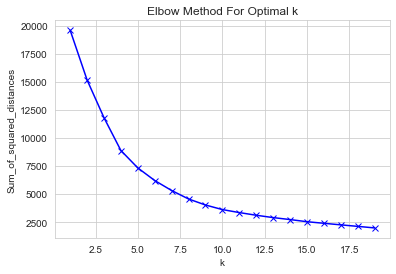

In [10]:
scaler = preprocessing.StandardScaler()
X_new = scaler.fit_transform(df_new)

find_k(20, X_new)

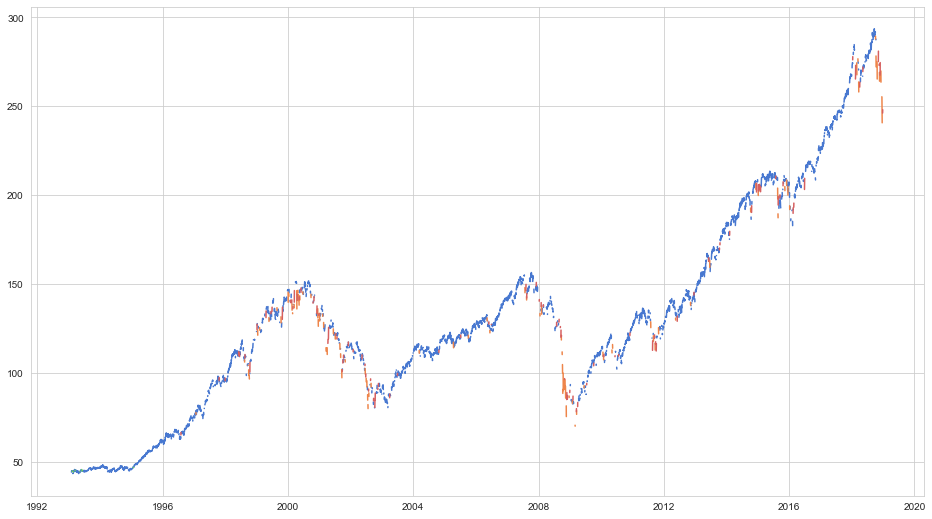

In [11]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters,
            init='k-means++', 
            n_init=n_clusters, 
            max_iter=300, 
            random_state=0)
y_new = km.fit_predict(X_new)

df_plot = df_new.copy(deep=True)
df_plot["CLOSE"] = df["CLOSE"]
df_plot["VOLUME"] = df["VOLUME"]
df_plot["clustering"] = y_new

fig = plot_market_regimes(n_clusters, df_plot)

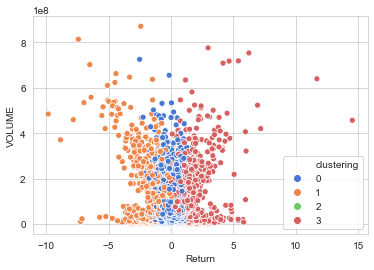

In [12]:
cmap = sns.color_palette("muted", n_clusters)
sns.scatterplot(data = df_plot, y="VOLUME", x="Return", hue="clustering", palette = cmap)

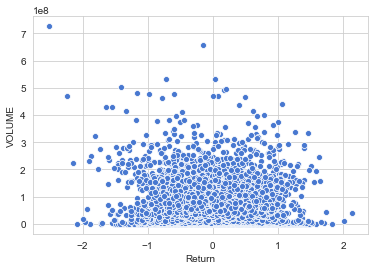

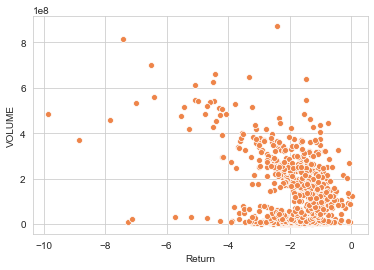

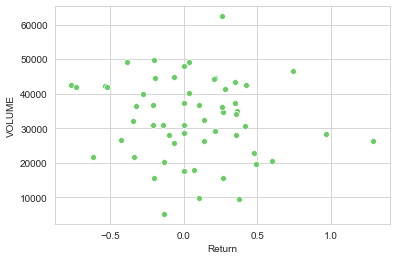

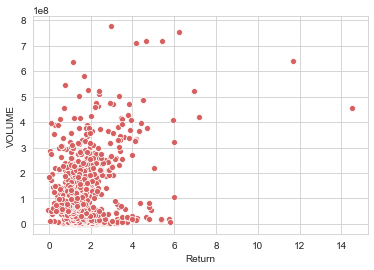

In [13]:
for i in range(0, n_clusters):
    plt.figure()
    sns.scatterplot(y=df_plot[df_plot["clustering"]==i]["VOLUME"], x=df_plot[df_plot["clustering"]==i]["Return"], color = cmap[i])

This clustering seems to make sense. It distinguishes between rather calm days (return between -1 and 1), bearish days (return >0) and bullish days (return <0). It also has a fourth category, where the volume is low, which occurs mainly at the beginning of the time series.

## Summary
* K-Means++ is not able to find clusters with non engineered data
* DBSCAN fails completely
* a reasonable grouping could be found with the help of the engineered data and the K-Means++
* clustering shows mostly a rather quiet day (blue), a bullish day (red), a bearish day (blue) and a very slow day (green)